# Graph Theory Algorithms with Neo4j and python

## Imports

In [197]:
from py2neo import Graph

In [198]:
from neo4j import GraphDatabase

In [199]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [200]:
import seaborn as sns
sns.set(style="ticks",palette="colorblind");

In [201]:
%matplotlib inline

In [202]:
from scipy import stats

## Conect to Neo4j

In [203]:
uri = 'bolt://neo4j-hdx:7687'

In [204]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

In [205]:
graph = Graph(uri, auth=("neo4j", "test"))

Obtain list of all years with data available:

In [206]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

## Centrality Algorithms

Degree of centrality:
https://neo4j.com/blog/graph-algorithms-neo4j-degree-centrality/ with a query

In [207]:
def degree_centrality_given_year(tx,year):
    return tx.run("MATCH (a:CountryYear) "
                  "WHERE a.year={0} "
                  "RETURN a.country as name, "
                  "size((a)-[:RESIDE_IN]->()) AS originates_from, "
                  "size((a)<-[:RESIDE_IN]-()) AS resides_in ".format(year))

In [208]:
year_D1 = 2017

In [209]:
with driver.session() as session:
    centrality_year = session.read_transaction(degree_centrality_given_year, year_D1).data()

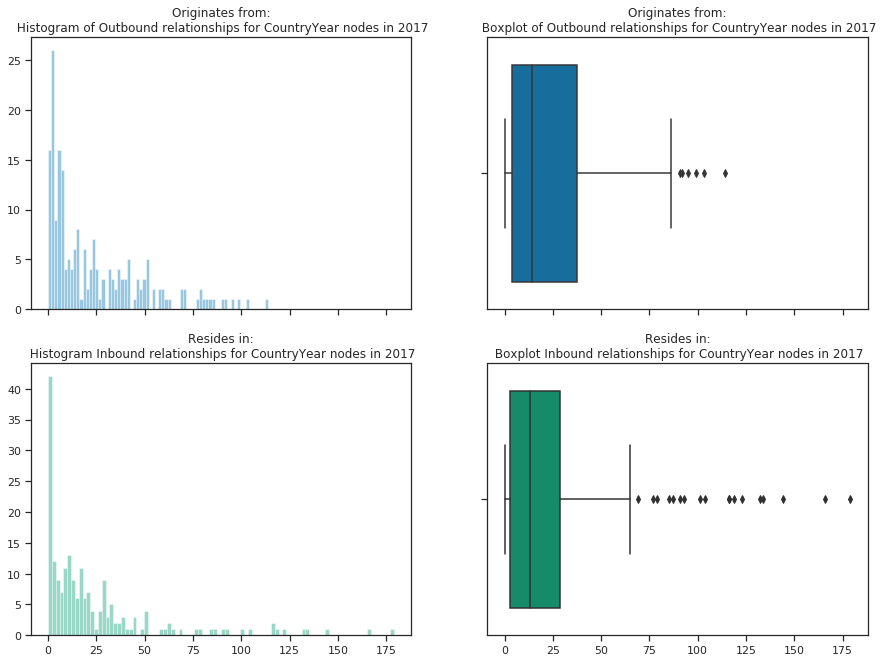

In [210]:
f, axes = plt.subplots(2, 2, figsize=(15, 11), sharex=True);

p1 = sns.distplot([data['originates_from'] for data in centrality_year], 
             kde=False, color="b", bins = 70, ax=axes[0,0])
p1.set_title("Originates from:\n Histogram of Outbound relationships for CountryYear nodes in {0}".format(year_D1));

p2 = sns.distplot([data['resides_in'] for data in centrality_year], 
             kde=False, color="g", bins = 90, ax=axes[1,0])
p2.set_title("Resides in:\n Histogram Inbound relationships for CountryYear nodes in {0}".format(year_D1));

p3 = sns.boxplot(x=[data['originates_from'] for data in centrality_year],color="b", ax=axes[0,1])
p3.set_title("Originates from:\n Boxplot of Outbound relationships for CountryYear nodes in {0}".format(year_D1));

p4 = sns.boxplot(x=[data['resides_in'] for data in centrality_year], color="g", ax=axes[1,1])
p4.set_title("Resides in:\n Boxplot Inbound relationships for CountryYear nodes in {0}".format(year_D1));

In [211]:
stats.describe([data['originates_from'] for data in centrality_year])

DescribeResult(nobs=199, minmax=(0, 114), mean=23.954773869346734, variance=635.6191563880005, skewness=1.3383048262981498, kurtosis=1.178025401579693)

In [212]:
stats.describe([data['resides_in'] for data in centrality_year])

DescribeResult(nobs=199, minmax=(0, 179), mean=23.954773869346734, variance=1070.6797624486067, skewness=2.360237215121091, kurtosis=5.855756996958778)

Get the mean of centrality for all years in years_list:

In [91]:
with driver.session() as session:
    centrality_all_years = {}
    for year in years_list:
        centrality_all_years[year] = session.read_transaction(degree_centrality_given_year, year).data()

In [113]:
mean_centrality_all_years_originate ={}
mean_centrality_all_years_reside ={}

for key in centrality_all_years.keys():
    mean_centrality_all_years_originate[key] = stats.describe([data['resides_in'] for data in centrality_all_years[key]]).mean
    mean_centrality_all_years_reside[key] = stats.describe([data['originates_from'] for data in centrality_all_years[key]]).mean

In [213]:
## Plot mean centrality trough the years

### Degree Centrality Algorithm

Use Degree Centrality if you’re attempting to analyze influence by looking at the number of incoming and outgoing relationships, or find the “popularity” of individ‐ ual nodes.

https://neo4j.com/docs/graph-algorithms/current/algorithms/degree-centrality/

In [220]:
def algo_degree_given_year(tx,year):
    return tx.run("CALL algo.degree( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target', "
                  "{{graph:'cypher', write: true, writeProperty: 'centrality'}})"
                  "YIELD nodes, loadMillis, computeMillis, writeMillis, write, writeProperty".format(year))

Include degree of centrality as property in nodes for all queried subgraphs (one per year):

In [221]:
with driver.session() as session:
    result_algo_degree = {}
    for year in years_list:
        result_algo_degree[year] = session.read_transaction(algo_degree_given_year, year).data()

### Betweeness Centrality Algorithm

Use to  use it to find bottlenecks, control points, and vulnerabilities.

https://neo4j.com/docs/graph-algorithms/current/algorithms/betweenness-centrality/

In [222]:
def algo_betweenness_given_year(tx,year):
    return tx.run("CALL algo.betweenness( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target', "
                  "{{graph:'cypher', write: true, writeProperty: 'betweenness'}})"
                  "YIELD nodes, minCentrality, maxCentrality, sumCentrality, loadMillis, computeMillis, writeMillis".format(year))

Include betweenness as property in nodes for all queried subgraphs (one per year):

In [223]:
with driver.session() as session:
    result_algo_betweenness = {}
    for year in years_list:
        result_algo_betweenness[year] = session.read_transaction(algo_betweenness_given_year, year).data()

## Comunity Detection Algorithms

Include comunity groupping as property in nodes:

### Louvain

https://neo4j.com/docs/graph-algorithms/current/algorithms/louvain/

In [224]:
def algo_louvain_given_year(tx,year):
    return tx.run("CALL algo.louvain( "
                  "'MATCH (n:CountryYear) WHERE n.year={0} RETURN id(n) AS id', "
                  "'MATCH (n)-[r:RESIDE_IN]->(m) RETURN id(n) AS source, id(m) AS target , r.affected_total as weight', "
                  "{{graph:'cypher', write: true, writeProperty: 'community_louvain', weightProperty:'weight' }})"
                  "YIELD nodes, communityCount, iterations, loadMillis, computeMillis, writeMillis".format(year))

In [225]:
with driver.session() as session:
    result_algo_labelPropagation = {}
    for year in years_list:
        result_algo_labelPropagation[year] = session.read_transaction(algo_louvain_given_year, year).data()